> ### Note on Labs and Assignments:
>
> 🔧 Look for the **wrench emoji** 🔧 — it highlights where you're expected to take action!
>
> These sections are graded and are not optional.
>

# IS 4487 Lab 9: Clustering

In this lab, we return to the **SF Rent** dataset that we used in **Lab 4: Data Understanding** and **Lab 5: Exploratory Data Analysis (EDA)**.

This time, we’ll explore how to segment the counties using both:
- **Manual clustering** based on business rules
- **Automatic clustering** using KMeans clustering

Segmentation helps identify meaningful groups within data, such as counties with high rent burden or low affordability. This is valuable for making targeted decisions in housing policy, urban planning, and social support.


## Outline

- Load and inspect the SF Rents dataset  
- Engineer and prepare features  
- Create manual segments using binning  
- Perform KMeans clustering for automatic segments  
- Visualize and compare results  

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Labs/lab_09_clustering.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## Dataset Overview

**Dataset:** `rent.csv`  
Source: [TidyTuesday – 2022-07-05](https://github.com/rfordatascience/tidytuesday/blob/main/data/2022/2022-07-05/rent.csv)

| Variable       | Type       | Description |
|----------------|------------|-------------|
| `post_id`      | Categorical| Unique listing ID |
| `date`         | Numeric    | Listing date (numeric format) |
| `year`         | Integer    | Year of listing |
| `nhood`        | Categorical| Neighborhood |
| `city`         | Categorical| City |
| `county`       | Categorical| County |
| `price`        | Numeric    | Listing price (USD) |
| `beds`         | Numeric    | Number of bedrooms |
| `baths`        | Numeric    | Number of bathrooms |
| `sqft`         | Numeric    | Square footage |
| `room_in_apt`  | Binary     | 1 = room in apartment |
| `address`      | Categorical| Street address |
| `lat`          | Numeric    | Latitude |
| `lon`          | Numeric    | Longitude |
| `title`        | Text       | Listing title |
| `descr`        | Text       | Listing description |
| `details`      | Text       | Additional details |


## Part 1: Importing the Data + Prepare for Segmentation

### Instructions:
- Import the `pandas` library.
- Import data from the rent.csv into a dataframe from the tidytuesday link.
- Use `.info()` and `.head()` to inspect the structure and preview the data.e structure and preview the data.
- Remove duplicates
- Handle missing values
- Remove outliers (for price, beds, baths, sqft)
- Fix data types
- Optionally impute or filter variables

In [1]:
import pandas as pd

# Load the dataset
url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2022/2022-07-05/rent.csv'
df = pd.read_csv(url)

# Get a quick overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200796 entries, 0 to 200795
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   post_id      200796 non-null  object 
 1   date         200796 non-null  int64  
 2   year         200796 non-null  int64  
 3   nhood        200796 non-null  object 
 4   city         200796 non-null  object 
 5   county       199402 non-null  object 
 6   price        200796 non-null  int64  
 7   beds         194188 non-null  float64
 8   baths        42675 non-null   float64
 9   sqft         64679 non-null   float64
 10  room_in_apt  200796 non-null  int64  
 11  address      3908 non-null    object 
 12  lat          7651 non-null    float64
 13  lon          4312 non-null    float64
 14  title        198279 non-null  object 
 15  descr        3254 non-null    object 
 16  details      8016 non-null    object 
dtypes: float64(5), int64(4), object(8)
memory usage: 26.0+ MB


In [2]:
df.head()

,post_id,date,year,nhood,city,county,price,beds,baths,sqft,room_in_apt,address,lat,lon,title,descr,details
0,pre2013_134138,20050111,2005,alameda,alameda,alameda,1250,2.0,2.0,NaN,0,NaN,NaN,NaN,$1250 / 2br - 2BR/2BA 1145 ALAMEDA DE LAS PU...,NaN,NaN
1,pre2013_135669,20050126,2005,alameda,alameda,alameda,1295,2.0,NaN,NaN,0,NaN,NaN,NaN,$1295 / 2br - Walk the Beach! 1 FREE MONTH + $...,NaN,NaN
2,pre2013_127127,20041017,2004,alameda,alameda,alameda,1100,2.0,NaN,NaN,0,NaN,NaN,NaN,$1100 / 2br - cottage,NaN,NaN
3,pre2013_68671,20120601,2012,alameda,alameda,alameda,1425,1.0,NaN,735.0,0,NaN,NaN,NaN,$1425 / 1br - 735ft² - BEST LOCATION SOUTHSHOR...,NaN,NaN
4,pre2013_127580,20041021,2004,alameda,alameda,alameda,890,1.0,NaN,NaN,0,NaN,NaN,NaN,"$890 / 1br - Classy ""Painted Lady"" VICTORIAN -...",NaN,NaN


In [3]:
# STEP 1: Drop duplicates
df = df.drop_duplicates(subset='post_id')

# STEP 2: Drop rows with nulls in essential columns
essential = ['price', 'beds', 'baths', 'sqft', 'lat', 'lon']
df = df.dropna(subset=essential)

# STEP 3: Remove outliers (common-sense filtering)
df = df[df['price'].between(500, 20000)]
df = df[df['beds'].between(0, 10)]
df = df[df['baths'].between(0.5, 10)]
df = df[df['sqft'].between(100, 5000)]

# STEP 4: Convert data types if needed
df['beds'] = df['beds'].astype(int)
df['baths'] = df['baths'].astype(float)  # decimal values allowed
df['sqft'] = df['sqft'].astype(int)
df['price'] = df['price'].astype(int)

# STEP 5: Reset index
df = df.reset_index(drop=True)

# Preview cleaned data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   post_id      1984 non-null   object 
 1   date         1984 non-null   int64  
 2   year         1984 non-null   int64  
 3   nhood        1984 non-null   object 
 4   city         1984 non-null   object 
 5   county       1979 non-null   object 
 6   price        1984 non-null   int64  
 7   beds         1984 non-null   int64  
 8   baths        1984 non-null   float64
 9   sqft         1984 non-null   int64  
 10  room_in_apt  1984 non-null   int64  
 11  address      1768 non-null   object 
 12  lat          1984 non-null   float64
 13  lon          1984 non-null   float64
 14  title        1855 non-null   object 
 15  descr        1847 non-null   object 
 16  details      1874 non-null   object 
dtypes: float64(3), int64(6), object(8)
memory usage: 263.6+ KB


In [4]:
df.head()

,post_id,date,year,nhood,city,county,price,beds,baths,sqft,room_in_apt,address,lat,lon,title,descr,details
0,4817227421,20141223,2014,alameda,alameda,alameda,1939,2,1.0,864,0,NaN,37.770600,-122.264800,"LIVE MORE, DRIVE LESS! JUST ACROSS THE BAY FRO...","Summer House Apartments 1826 Poggi St, Alameda...","2BR / 1Ba 864ft2 apartment date=""2014-12-23"" ..."
1,4710888130,20141012,2014,alameda,alameda,alameda,2250,2,1.0,1080,0,659,37.772835,-122.248585,2br Victortian Duplex Garden Apt.,"This 1903 ""Workingman's Victorian"" on a quiet ...","2BR / 1Ba 1080ft2 apartment date=""2014-11-02""..."
2,5961989126,20170126,2017,alameda,alameda,alameda,3995,3,2.0,1787,0,NaN,37.759231,-122.247190,3 BR/2 BA Queene Anne on Park St.,This charming 1787 sq ft meticulously maintain...,"3BR / 2Ba1787ft2 data-date=""2017-02-01"" data-t..."
3,4935175730,20150316,2015,alameda,alameda,alameda,2536,2,2.0,1225,0,NaN,37.753609,-122.249081,Spacious 2BR/2BA in a Great Community!,Tower Apartments CALL US: show contact infox3...,"2BR / 2Ba 1225ft2 apartment date=""2015-04-19""..."
4,4988581576,20150421,2015,alameda,alameda,alameda,2650,2,1.0,950,0,497,37.758922,-122.263314,"Upgraded 2B w/ Pool View, Short Walk to School...",Enjoy and experience the relaxing atmosphere o...,"2BR / 1Ba 950ft2 apartment date=""2015-04-20"" ..."


## Part 2: Engineer and Prepare Features

We’ll select features for clustering:
- Property: `price`, `beds`, `baths`, `sqft`
- Geographic: `lat`, `lon`

We’ll standardize features to ensure fair weighting in distance-based clustering.

### Why This Matters:
Standardization avoids giving larger-scale variables (like `price`) more influence.

### Things to think about:
- Should all variables be scaled?
- Do geographic coordinates need standardization?


In [5]:
from sklearn.preprocessing import StandardScaler

# Select and scale features
features = ['price', 'beds', 'baths', 'sqft', 'lat', 'lon']
segment_df = df[features].copy()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(segment_df)

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=features)
scaled_df.head()


,price,beds,baths,sqft,lat,lon
0,-0.657774,-0.036416,-0.772941,-0.536093,0.429432,-0.403353
1,-0.473068,-0.036416,-0.772941,-0.165325,0.436382,-0.339893
2,0.563306,0.855552,0.682697,1.048255,0.394079,-0.334434
3,-0.303210,-0.036416,0.682697,0.083571,0.376597,-0.341835
4,-0.235504,-0.036416,-0.772941,-0.388473,0.393118,-0.397537


### 🔧 Try It Yourself – Part 2

1. Why should lat/lon (latitude and longitude) be scaled before clustering? What would happen if they weren’t? (There’s no coding here, just write your response below.)

Latitude and longitude should be scaled before clustering because these are large values, and can throw off algorithms that rely on distance calculations. Clustering performs better when features are scaled because it makes the values more equal, and thus more comparable. Latitude and longitude have different ranges, so they need to be scaled so we can compare them easier.

## Part 3: Create Manual Segments Using Binning

Let’s group listings by price into:
- **Low**: < $2,000
- **Mid**: $2,000–$4,000
- **High**: > $4,000

### Why This Matters:
Manual bins based on thresholds offer simple segmentation — useful when business rules exist.

### Things to think about:
- Are fixed cutoffs better than percentiles?
- Should you also bin square footage?


In [6]:
# Create price segments
df['price_segment'] = pd.cut(
    df['price'],
    bins=[0, 2000, 4000, float('inf')],
    labels=['Low', 'Mid', 'High']
)

df['price_segment'].value_counts()


,count
price_segment,
Mid,1195
Low,493
High,296


### 🔧 Try It Yourself – Part 3

1. Create a column called `sqft_segment` using bins:  
  - Small: `< 800`, Medium: `800–1400`, Large: `>1400`  
2. Count how many listings fall into each `sqft_segment` using `.value_counts()`  
3. Use `.head()` to preview both `price_segment` and `sqft_segment`

Square Footage Segment Value Counts:
sqft_segment
Medium    944
Small     536
Large     504
Name: count, dtype: int64



Preview of price_segment and sqft_segment:


,price_segment,sqft_segment
0,Low,Medium
1,Mid,Medium
2,Mid,Large
3,Mid,Medium
4,Mid,Medium


## Part 4: Perform KMeans Clustering

We’ll create two sets of clusters:
1. **Feature-based** (price, beds, baths, sqft)
2. **Geographic-based** (lat, lon)

### Why This Matters:
Unsupervised clustering finds hidden patterns — useful for market segmentation, targeting, etc.

### Things to think about:
- How many clusters should you use?
- How do results differ between property and location clusters?


In [10]:
from sklearn.cluster import KMeans

# Select only the standardized property features
X_feat = scaled_df[['price', 'beds', 'baths', 'sqft']]

# Apply KMeans clustering with 4 clusters
kmeans_feat = KMeans(n_clusters=4, random_state=1)
scaled_df['feature_cluster'] = kmeans_feat.fit_predict(X_feat)

# Show number of listings in each cluster
scaled_df['feature_cluster'].value_counts()


,count
feature_cluster,
0,962
3,652
1,318
2,52


In [11]:
# Select only standardized geographic coordinates
X_geo = scaled_df[['lat', 'lon']]

# Apply KMeans clustering with 5 clusters
kmeans_geo = KMeans(n_clusters=5, random_state=1)
scaled_df['geo_cluster'] = kmeans_geo.fit_predict(X_geo)

# Show number of listings in each geographic cluster
scaled_df['geo_cluster'].value_counts()

,count
geo_cluster,
1,692
2,610
0,335
4,230
3,117


### 🔧 Try It Yourself – Part 4

1. Run KMeans again using `k=3` (3 clusters instead of 4). Then compare the value counts of the old KMeans with your new KMeans.
2. Plot a histogram of `price` grouped by `feature_cluster`  

Value counts for KMeans with k=3:
feature_cluster_k3
0    1032
1     807
2     145
Name: count, dtype: int64

Value counts for KMeans with k=4:
feature_cluster
0    962
3    652
1    318
2     52
Name: count, dtype: int64


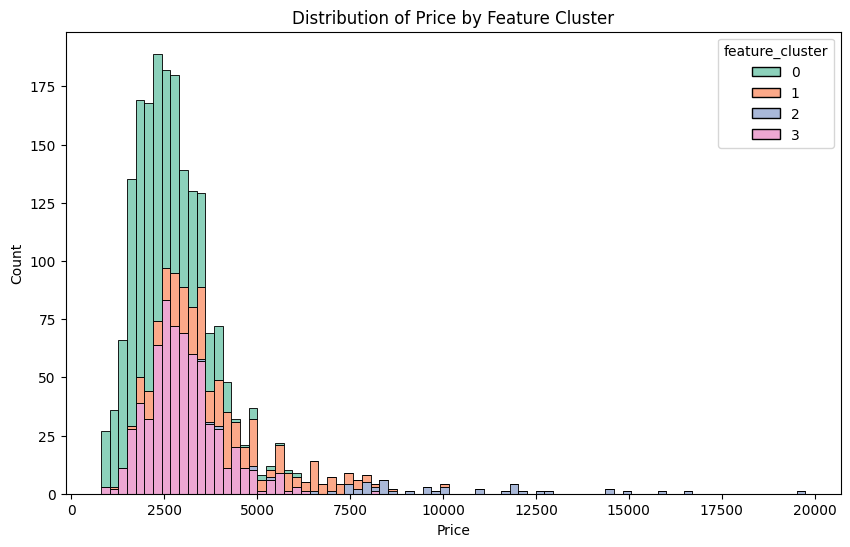

In [16]:
# Plot a histogram of price grouped by feature_cluster
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='price', hue='feature_cluster', multiple="stack", palette='Set2')
plt.title('Distribution of Price by Feature Cluster')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

## Part 5: Visualize and Compare Results

We’ll now visualize:
- Clusters on a map (lat/lon)
- Clusters in price vs sqft space

### Why This Matters:
Visual validation helps determine if clusters are interpretable and useful.

### Things to think about:
- Are location clusters geographically meaningful?
- Do property clusters separate by price or size?

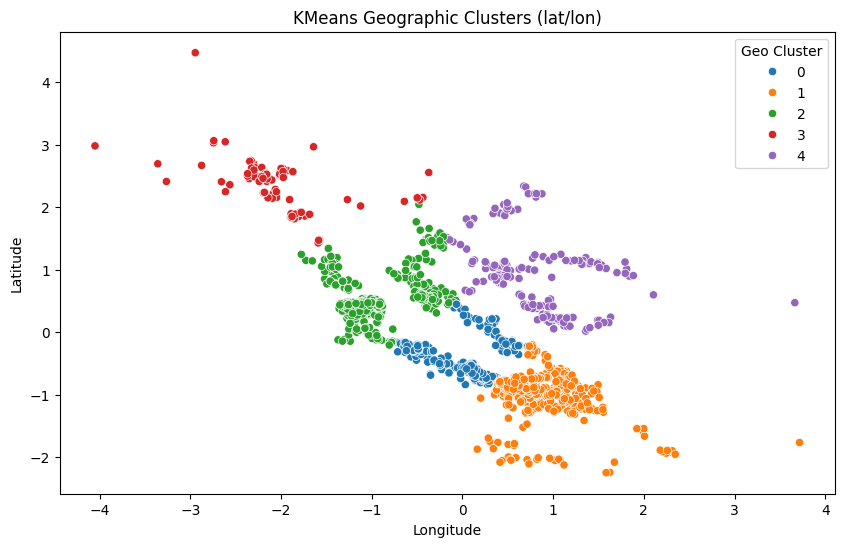

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot latitude vs longitude colored by geographic cluster
plt.figure(figsize=(10,6))
sns.scatterplot(data=scaled_df,
                x='lon',
                y='lat',
                hue='geo_cluster',
                palette='tab10')

plt.title("KMeans Geographic Clusters (lat/lon)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title='Geo Cluster')
plt.show()

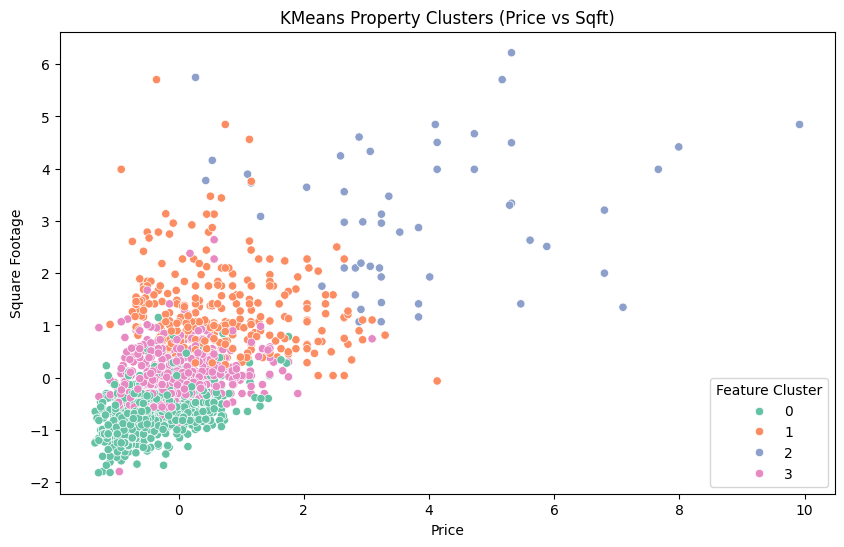

In [18]:
# Plot price vs square footage colored by feature cluster
plt.figure(figsize=(10,6))
sns.scatterplot(data=scaled_df,
                x='price',
                y='sqft',
                hue='feature_cluster',
                palette='Set2')

plt.title("KMeans Property Clusters (Price vs Sqft)")
plt.xlabel("Price")
plt.ylabel("Square Footage")
plt.legend(title='Feature Cluster')
plt.show()

### 🔧 Try It Yourself – Part 5

In past assignments you’ve created scatterplots where the size of each point depended on how large each value was. And you’ve created scatterplots where the color of each point was assigned many or few colors.

1. Add `beds` as the **point size** in your scatterplot of `price` vs `sqft`  
2. Add `baths` as the **point style** in your `sns.scatterplot()`  
3. Group by `feature_cluster` and calculate:
  - Average `price`
  - Average `sqft`
  - Average `beds`  


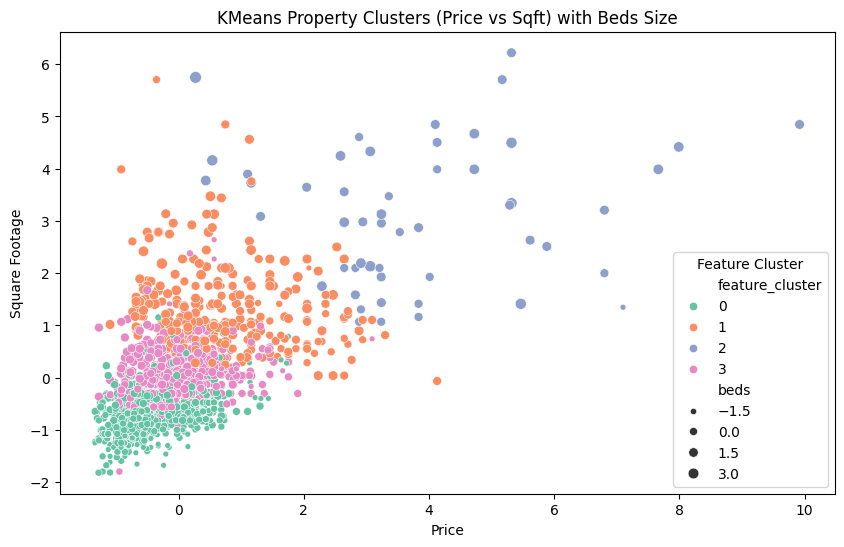

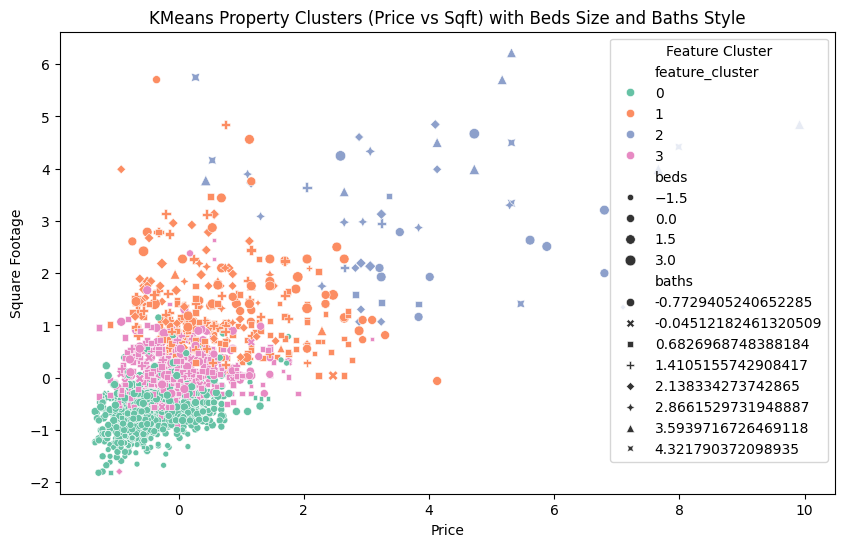

Average values by Feature Cluster:


,price,sqft,beds
feature_cluster,,,
0,2362.111227,801.034304,1.257796
1,4175.820755,1917.572327,3.462264
2,9497.000000,2998.923077,4.134615
3,2991.121166,1223.128834,2.335890


## Part 6: Evaluate the Fit for your Clusters

We’ll now use three methods to evaluate the fit:
- WCSS
- Silhouette score
- Davies-bouldin index

### Why This Matters:
Clusters are difficult to visualize when they are based on more than 3 variables.  A statistical score will evaluate the fit across all of the variables.

### Things to think about:
- Lower WCSS = tighter, better-defined clusters
- Silhouette score ranges from -1 to 1.  Higher values = better clustering
- Lower Davies-Boulding Index = better clustering

### 🔧 Try It Yourself – Part 6

Calculate the three scores for your **feature-based** cluster model by using the following methods:
- WCSS
- Silhouette score
- Davies-bouldin index

WCSS for feature-based clusters: 3092.398615522004


Silhouette Score for feature-based clusters: 0.3348895353743559


In [25]:
from sklearn.metrics import davies_bouldin_score

# Calculate Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(X_feat, scaled_df['feature_cluster'])
print(f"Davies-Bouldin Index for feature-based clusters: {davies_bouldin_avg}")

Davies-Bouldin Index for feature-based clusters: 1.279690827078391


## 🔧 Part 7: Reflection (100 words or less per question)

1. Which method—manual binning or KMeans clustering—gave you more useful insights?
2. How might missing data or outliers affect your segmentation results?


KMeans clustering was easier to visualize, but the clusters were not super well defined, making insights a little bit harder than with manual binning. I appreciated the ease and simplicity of manual binning compared to KMeans clustering, but manual binning did not give me the useful visualizations that clustering did. Overall, I preferred the insights from manual binning. I think I would prefer KMeans clustering when analyzing harder-to-understand relationships having to do with statistical distance. In this case, manual binning worked just great and was easy to understand.



Missing data and extreme outliers would negatively affect the integrity and reliability of segmentation results. These things can introduce bias and skew data in one direction or another, which is never good for analysis. Missing data can make algorithms much less efficient, and even lead to misrepresented data. Outliers can skew averages, which would lead to inaccurate segment boundaries. Missing data and extreme outliers should be taken care of before we get to the segmentation phase of analytics.



## Export Your Notebook to Submit in Canvas
- Use the instructions from Lab 1

In [26]:
!jupyter nbconvert --to html "lab_09_clustering.ipynb"

[NbConvertApp] Converting notebook lab_09_clustering.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 969069 bytes to lab_09_clustering.html
